# Classification for Adult Dataset

`Nome`: Henrique Abe Fukushima

`NUSP`: 13682465

`HASH`: 70

In this notebook, we'll explore the Adult dataset with four different classifiers that were studied in class. In the EP1, we performed an Exploratory Data Analysis (EDA) which resulted in both data cleaning and feature selection. Thus, here we'll skip EDA and jump straight into the data preparation. Then, we'll have one section for training and tuning each of the classifiers. The last section will be a final analysis, comparing the models to find out which has the best performance for this task. 

This notebook is structured as follows:

1. Dataprep
2. Training Function
3. Logistic Regression
4. Random Forest
5. Support Vector Machine (SVM)
6. Xgboost
7. Classifiers Comparison
8. Conclusion and Kaggle Submission

We begin by importing libraries and data.

In [81]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Preprocessing Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Classifiers' Libraries
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.svm import SVC                         # Support Vector Classifier
from xgboost import XGBClassifier                   # XGBoost

# Training and Validation Libraries
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

In [82]:
# Read data
df_train = pd.read_csv('data/train_data.csv')
df_test = pd.read_csv('data/test_data.csv')

# Rename columns
df_train.set_index('Id', inplace=True)
df_test.set_index('Id', inplace=True)
df_train.rename(columns={'age': 'Age',
                   'workclass': 'Workclass',
                   'fnlwgt': 'Final Weight',
                   'education': 'Education',
                   'education.num': 'Education Number',
                   'marital.status': 'Marital Status',
                   'occupation': 'Occupation',
                   'relationship': 'Relationship',
                   'race': 'Race',
                   'sex': 'Sex',
                   'capital.gain': 'Capital Gain',
                   'capital.loss': 'Capital Loss',
                   'hours.per.week': 'Hours per Week',
                   'native.country': 'Native Country',
                   'income': 'Target'
                   }, inplace=True)
df_test.rename(columns={'age': 'Age',
                    'workclass': 'Workclass',
                    'fnlwgt': 'Final Weight',
                    'education': 'Education',
                    'education.num': 'Education Number',
                    'marital.status': 'Marital Status',
                    'occupation': 'Occupation',
                    'relationship': 'Relationship',
                    'race': 'Race',
                    'sex': 'Sex',
                   'capital.gain': 'Capital Gain',
                   'capital.loss': 'Capital Loss',
                   'hours.per.week': 'Hours per Week',
                   'native.country': 'Native Country',
                    }, inplace=True)
df_train.head()

,Age,Workclass,Final Weight,Education,Education Number,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per Week,Native Country,Target
Id,,,,,,,,,,,,,,,
16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


# 1. Dataprep

We'll reuse the same steps of data cleaning, feature engineering and feature selection of the EP1. 

## 1.1 Data Cleaning
First, we'll remove null and duplicated data.

In [83]:
# Null Values
df_train.replace("?", np.nan, inplace=True)
df_train.isna().sum()

Age                    0
Workclass           1836
Final Weight           0
Education              0
Education Number       0
Marital Status         0
Occupation          1843
Relationship           0
Race                   0
Sex                    0
Capital Gain           0
Capital Loss           0
Hours per Week         0
Native Country       583
Target                 0
dtype: int64

In [84]:
# Drop Null Values
df_train = df_train.dropna()

In [85]:
# Duplicated Rows
print('Duplicated rows:', df_train.duplicated().sum())

Duplicated rows: 23


In [86]:
# Drop Duplicated Rows
df_train.drop_duplicates(inplace=True)

## 1.2 Feature Engineering

Now we transform some categorical covariates into binary variables

In [87]:
def race_feat(race):
    if race == 'White':
        return 1
    else:
        return 0
    
def country_feat(country):
    if country == 'United-States':
        return 1
    else:
        return 0

def sex_feat(sex):
    if sex == 'Male':
        return 1
    else:
        return 0
    
def income_feat(income):
    if income == '>50K':
        return 1
    else:
        return 0
    
def married_feat(status):
    if status == 'Married-civ-spouse' or status == 'Married-AF-spouse':
        return 1 # With spouse
    else:
        return 0 # No spouse

def workclass_feat(workclass):
    if workclass == 'Never-worked' or workclass=='Without-pay':
        return 0
    else:
        return 1


In [88]:
# Apply binary categorization
df_train['Race'] = df_train['Race'].apply(race_feat)
df_train['Native Country'] = df_train['Native Country'].apply(country_feat)
df_train['Sex'] = df_train['Sex'].apply(sex_feat)
df_train['Target'] = df_train['Target'].apply(income_feat)
df_train['Marital Status'] = df_train['Marital Status'].apply(married_feat)
df_train['Workclass'] = df_train['Workclass'].apply(workclass_feat)

The education has an order, so we'll transform it into ordered numerical values:

In [89]:
def education_feat(education):
    if education == 'Preschool':
        return 1
    elif education == '1st-4th':
        return 2
    elif education == '5th-6th':
        return 3
    elif education == '7th-8th':
        return 4
    elif education == '9th':
        return 5
    elif education == '10th':
        return 6
    elif education == '11th':
        return 7
    elif education == '12th':
        return 8
    elif education == 'HS-grad':
        return 9
    elif education == 'Some-college':
        return 10
    elif education == 'Assoc-voc':
        return 11
    elif education == 'Assoc-acdm':
        return 12
    elif education == 'Bachelors':
        return 13
    elif education == 'Masters':
        return 14
    elif education == 'Prof-school':
        return 15
    elif education == 'Doctorate':
        return 16

In [90]:
df_train['Education'] = df_train['Education'].apply(education_feat)

The other non-binary categorical features can be encoded with LabelEncoder

In [91]:
# Columns to be encoded
label_encode_cols = ['Occupation', 'Relationship']

# LabelEncoder
label_encoder = LabelEncoder()
for col in label_encode_cols:
    df_train[col] = label_encoder.fit_transform(df_train[col])

Now we normalize the data

In [92]:
# Select numerical columns for normalization
numerical_cols = ['Age', 'Final Weight', 'Education', 'Education Number', 'Occupation', 'Relationship', 'Capital Gain', 'Capital Loss', 'Hours per Week']
scaler = StandardScaler()
df_train[numerical_cols] = scaler.fit_transform(df_train[numerical_cols])
df_train.head()

,Age,Workclass,Final Weight,Education,Education Number,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per Week,Native Country,Target
Id,,,,,,,,,,,,,,,
16280,-0.338250,1,0.143789,-0.048039,-0.048039,0,-0.734634,0.987428,1,1,-0.147495,-0.218677,0.255892,1,0
16281,1.489427,1,1.138464,-1.617476,-1.617476,1,1.746805,-0.885667,1,1,-0.147495,-0.218677,-0.078033,1,0
16282,-1.023629,1,-0.413431,-0.048039,-0.048039,0,0.009798,-0.261302,1,1,-0.147495,-0.218677,0.088930,1,0
16283,-1.099782,1,-0.481378,-0.048039,-0.048039,0,-1.479065,-0.261302,1,0,-0.147495,-0.218677,-0.078033,1,0
16284,1.413274,1,0.653856,-0.440398,-0.440398,1,1.746805,-0.885667,1,1,0.551375,-0.218677,1.591590,0,1


## 1.3 Feature Selection

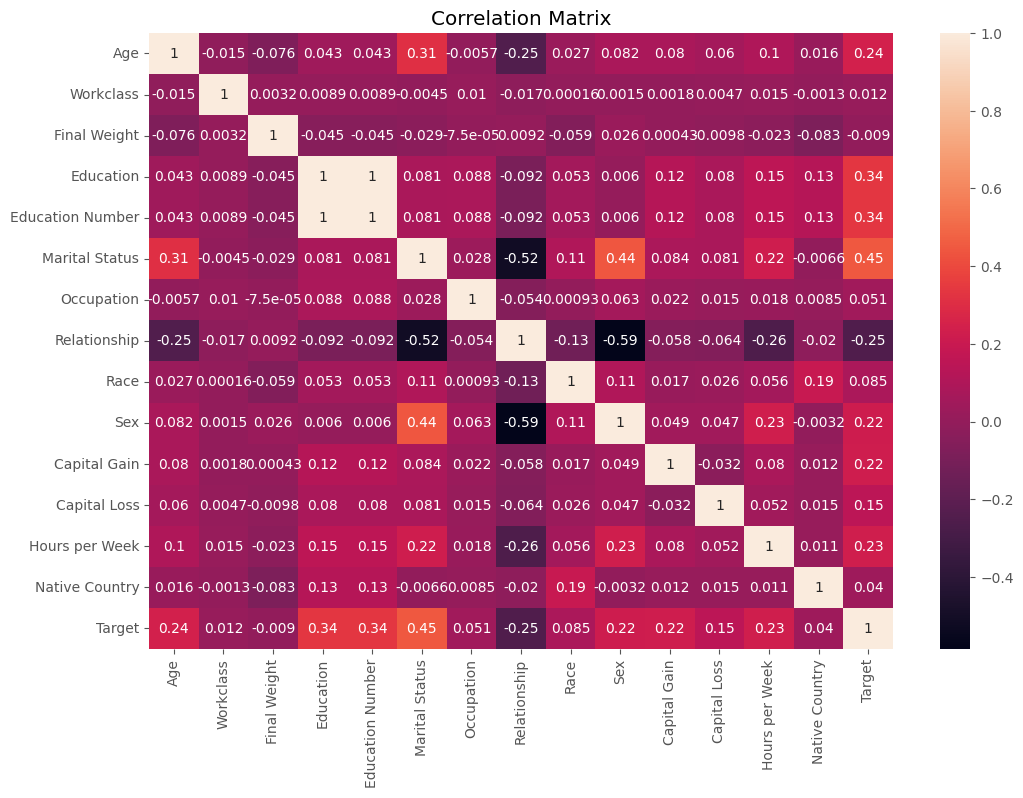

In [93]:
df_corr = df_train.corr()
plt.figure(figsize=(12,8))
plt.title('Correlation Matrix')
sns.heatmap(df_corr, annot=True)
plt.show()

The conclusions from EP1 were the following:
- Education and Education encodes the same information, so we can exclude one of them;
- Native Country and Race has low correlation with Target, so we can exclude it;
- Relationship is a redundant feature;
- As we suspected, workclass has low correlation with Target, as it's category is mainly 'Private' and it is in the same proportions of income.
- The 'Final Weight' represents the sampling weight assigned to each individual in the dataset, reflecting the number of people in the population that each data point is meant to represent in a survey or study. This is useful for certain kinds of demographic analysis, but irrelevant for predicting income.
So this feature must be excluded as it could be adding noise and increasing the dimensionality and this negatively impacts the model’s ability to generalize.

So we can drop some features as follows:

In [94]:
# Create Features and Target for training
X_train = df_train.drop(['Education Number', 'Native Country', 'Final Weight', 'Relationship', 'Race', 'Target'], axis=1)
Y_train = df_train['Target']
X_train.head()

,Age,Workclass,Education,Marital Status,Occupation,Sex,Capital Gain,Capital Loss,Hours per Week
Id,,,,,,,,,
16280,-0.338250,1,-0.048039,0,-0.734634,1,-0.147495,-0.218677,0.255892
16281,1.489427,1,-1.617476,1,1.746805,1,-0.147495,-0.218677,-0.078033
16282,-1.023629,1,-0.048039,0,0.009798,1,-0.147495,-0.218677,0.088930
16283,-1.099782,1,-0.048039,0,-1.479065,0,-0.147495,-0.218677,-0.078033
16284,1.413274,1,-0.440398,1,1.746805,1,0.551375,-0.218677,1.591590


## 1.4 Split Train and Validation Data

We'll split the current `X_train` and `Y_train` into training and validation sets so we can compare the performances of the different classifiers over the same `X_val` and `Y_val` sets. In the end, we'll use the best classifier to predict the `Y_test` from the `X_test`.

In [95]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

## 1.5 Test Dataprep

Finally, we perform the same transformations to the test dataset.

In [96]:
# Apply binary categorization
df_test['Race'] = df_test['Race'].apply(race_feat)
df_test['Native Country'] = df_test['Native Country'].apply(country_feat)
df_test['Sex'] = df_test['Sex'].apply(sex_feat)
df_test['Marital Status'] = df_test['Marital Status'].apply(married_feat)
df_test['Workclass'] = df_test['Workclass'].apply(workclass_feat)

# Apply education feature
df_test['Education'] = df_test['Education'].apply(education_feat)

# LabelEncoder
label_encoder = LabelEncoder()
for col in label_encode_cols:
    df_test[col] = label_encoder.fit_transform(df_test[col])

# StandardScaler
df_test[numerical_cols] = scaler.fit_transform(df_test[numerical_cols])

# Feature Selection
X_test = df_test.drop(['Education Number', 'Native Country', 'Final Weight', 'Relationship', 'Race'], axis=1)

# Display
X_test.head()

,Age,Workclass,Education,Marital Status,Occupation,Sex,Capital Gain,Capital Loss,Hours per Week
Id,,,,,,,,,
0,-0.994190,1,1.140012,0,0.805968,1,-0.142666,-0.218069,0.289097
1,1.821945,1,1.140012,1,-0.611157,1,-0.142666,-0.218069,0.369230
2,-0.560938,1,1.529506,0,-0.611157,0,-0.142666,-0.218069,-0.031433
3,0.449982,1,-0.417965,0,0.097406,1,-0.142666,-0.218069,-0.031433
4,1.821945,1,1.140012,1,-0.611157,1,-0.142666,-0.218069,0.769892


Now we can train the classifiers.

# 2. Training Function

The dataset is imbalanced (see cell below). Some techniques were explored like oversampling and downsampling with artificial samples, but they didn't yield great results. So to deal with this, we used `StratifiedKFold` cross validation and we scored the models with the `f1_weighted` metric.

In [97]:
# Count for each class
print('Training Set Imbalance')
print(Y_train.value_counts())
print()
print('Validation Set Imbalance')
print(Y_val.value_counts())

Training Set Imbalance
Target
0    18142
1     5968
Name: count, dtype: int64

Validation Set Imbalance
Target
0    4490
1    1538
Name: count, dtype: int64


We define a training function that we'll use for all classifiers. It has the model and the grid of hyperparameters as input and returns training time, best model score, best model parameters and some performance metrics. We'll perform a `GridSearchCV` with stratified k-fold cross validation to find the best hyperparameters for each model.

In [98]:
def train_model(model, param_grid, X_train, Y_train, X_val, Y_val, scoring='f1_weighted'):

    # Define Stratified K-Fold
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Set up GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,  
        cv=stratified_kfold,  
        verbose=1,
        n_jobs=-1 
    )

    # Train the model
    start = time()
    grid_search.fit(X_train, Y_train)
    end = time()
    train_time = end - start
    print(f'Training Time: {train_time:.2f}s')

    # Best parameters and performance
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validation Score: {best_score:.4f}")
    print()

    # Evaluate the model on the validation set
    best_model = grid_search.best_estimator_
    y_val_pred = best_model.predict(X_val)
    report_metrics = classification_report(Y_val, y_val_pred, output_dict=True)
    acc = report_metrics['accuracy']
    f1_weighted = report_metrics['weighted avg']['f1-score']
    
    print(classification_report(Y_val, y_val_pred))

    # Create dictionary
    results = {'best_model': best_model,
                  'best_params': best_params,
                  'accuracy': acc,
                  'f1_weighted': f1_weighted,
                  'training_time': train_time
                  }
    
    return results

# 3. Logistic Regression

$$P(y=1|X) = \cfrac{1}{1 + e^{-(W_0 + \vec{W}\cdot \vec{X})}}$$

The Logistic Regression equation doesn't have any hyperparameter to tune, however we can introduce regularization, then the strength of the penalization will be the hyperparameter. We'll use the solver `liblinear` as it supports both the L1 (Lasso) and L2 (Ridge) penalties.

In [99]:
# Define the model
logreg = LogisticRegression(solver='liblinear')

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2']  
}

# Training Function
results_logreg = train_model(logreg, param_grid, X_train, Y_train, X_val, Y_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training Time: 17.31s
Best Parameters: {'C': 10, 'penalty': 'l1'}
Best Cross-Validation Score: 0.8306

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      4490
           1       0.73      0.57      0.64      1538

    accuracy                           0.84      6028
   macro avg       0.80      0.75      0.77      6028
weighted avg       0.83      0.84      0.83      6028



# 4. Random Forest

Random Forests are ensemble models based on decision trees. They have several hyperparameters that can be tuned to optimize performance:
- `n_estimators`: number of trees in the forest;

- `max_depth`: maximum depth of each tree;

- `min_samples_split`: minimum number of samples required to split an internal node;

- `min_samples_leaf`: minimum number of samples required to be at a leaf node;

- `max_features`: The number of features to consider when looking 
for the best split;

- `criterion`: measure of the quality of a split.

In [100]:
# Define the model
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Training Function
results_rf = train_model(rf, param_grid, X_train, Y_train, X_val, Y_val)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Training Time: 69.51s
Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.8528

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4490
           1       0.78      0.64      0.70      1538

    accuracy                           0.86      6028
   macro avg       0.83      0.79      0.81      6028
weighted avg       0.86      0.86      0.86      6028



# 5. Support Vector Machine (SVM)

SVM works by finding a hyperplane that best separates the classes in the feature space. To select the best hyperplane, it considers the one with the highest margin - that is the distance from the hyperplane to the closest data point. This margin can be relaxed to allow some points inside of it (which is called a *soft margin*). 

The advantages of the SVM is that it is not hardly affected by outliers, as the points that matter are those that are close to the margin. Also, for non separable data, SVM has the **kernel trick** which transforms data into higher dimensions to make it separable. 

We'll perform a grid search for the following hyperparameters of SVM:
- `C`: regularization parameter
- `kernel`: kernels to explore
- `gamma`: kernel coefficient (for 'rbf')

In [101]:
# Define the model
svc = SVC()

# Define hyperparameter grid
param_grid = {
    'C': [0.1, 10],
    'kernel': ['linear',  'rbf'],
    'gamma': [1, 0.01],
}

# Training Function
results_svm = train_model(svc, param_grid, X_train, Y_train, X_val, Y_val)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training Time: 76.84s
Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.8387

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4490
           1       0.74      0.60      0.66      1538

    accuracy                           0.84      6028
   macro avg       0.81      0.76      0.78      6028
weighted avg       0.84      0.84      0.84      6028



# 6. Xgboost

XGBoost (eXtreme Gradient Boosting) is a powerful ensemble algorithm based on gradient boosting. It builds decision trees sequentially, where each tree attempts to correct the errors of the previous one.

XGBoost offers several hyperparameters for fine-tuning to improve model performance.

In [102]:
# Define the model
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.5],
    'learning_rate': [0.1, 0.4],
    'n_estimators': [100, 200, 500]
}

# Training Function
results_xgb = train_model(xgb, param_grid, X_train, Y_train, X_val, Y_val)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Training Time: 78.82s
Best Parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 500}
Best Cross-Validation Score: 0.8635

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4490
           1       0.79      0.65      0.71      1538

    accuracy                           0.87      6028
   macro avg       0.84      0.80      0.81      6028
weighted avg       0.86      0.87      0.86      6028



# 7. Comparison

We'have picked the best models for each classifier type and now we'll compare them. We've already calculated metrics in the classifications reports and we can plot a visual comparison of the accuracies and f1-score of our models. Plus, we can compute the ROC curve for each model and them calculate the area under the curve (AUC) - the bigger the AUC, the better the model. 

In [103]:
def plot_metrics(results_models):

    models = []
    accuracies = []
    f1_scores = []
    training_times = []

    for name, results in results_models.items():

        # Extract metrics
        models.append(name)
        training_times.append(results['training_time'])
        accuracies.append(results['accuracy'])
        f1_scores.append(results['f1_weighted'])

    # Convert categories to a range for the y-axis
    y_positions = np.arange(0, len(models)*2, step=2)

    # Bar width
    bar_width = 0.4

    # Create the plot
    plt.figure(figsize=(12, 7))
    plt.barh(y_positions - bar_width / 2, accuracies, height=bar_width, color='salmon', label='Accuracy')
    plt.barh(y_positions + bar_width / 2, f1_scores, height=bar_width, color='cornflowerblue', label='F1-Weighted')

    # Add labels and legend
    plt.yticks(y_positions, models)  # Add category labels
    plt.title('Metrics Comparison for Classifiers')
    plt.xlabel('Score')
    plt.ylabel('Models')
    plt.legend(loc='best')
    plt.tight_layout()

    # Show the plot
    plt.show()
    
    return

def plot_roc_curves(results_models, X_test, y_test):
    
    plt.figure(figsize=(10, 7))

    for name, results in results_models.items():

        model = results['best_model']
        # Predict probabilities or decision function
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_prob = model.decision_function(X_test)
        else:
            continue  # Skip models that don't provide probability estimates

        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.title('ROC Curve Comparison')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return

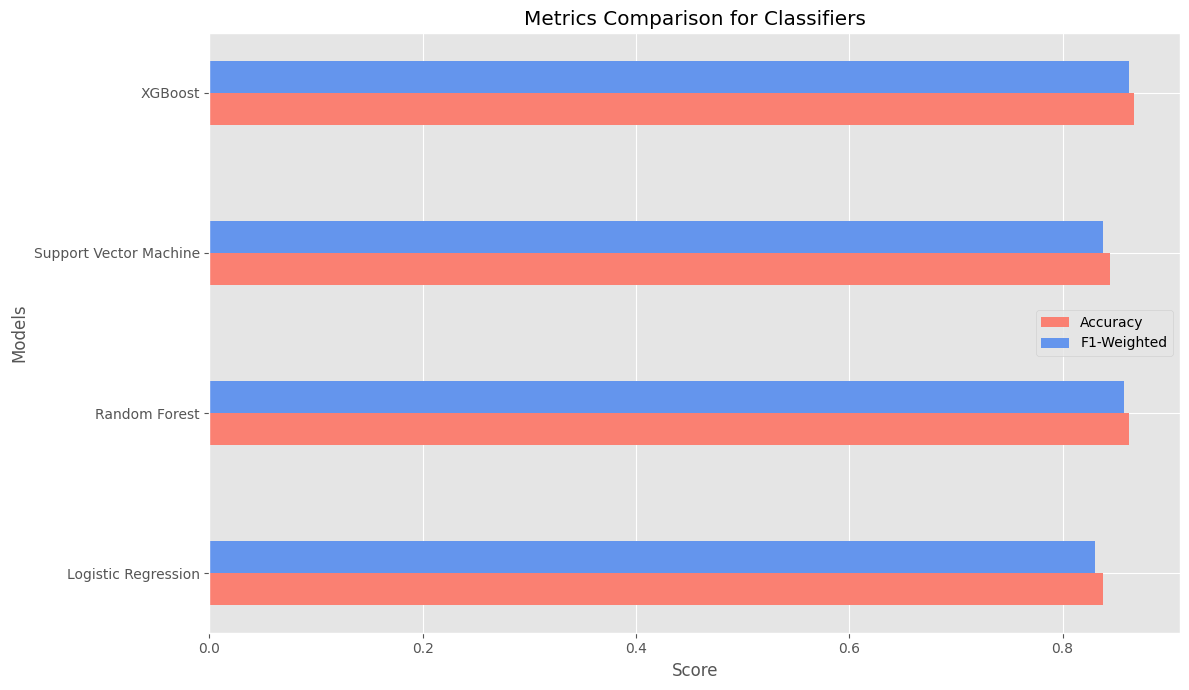

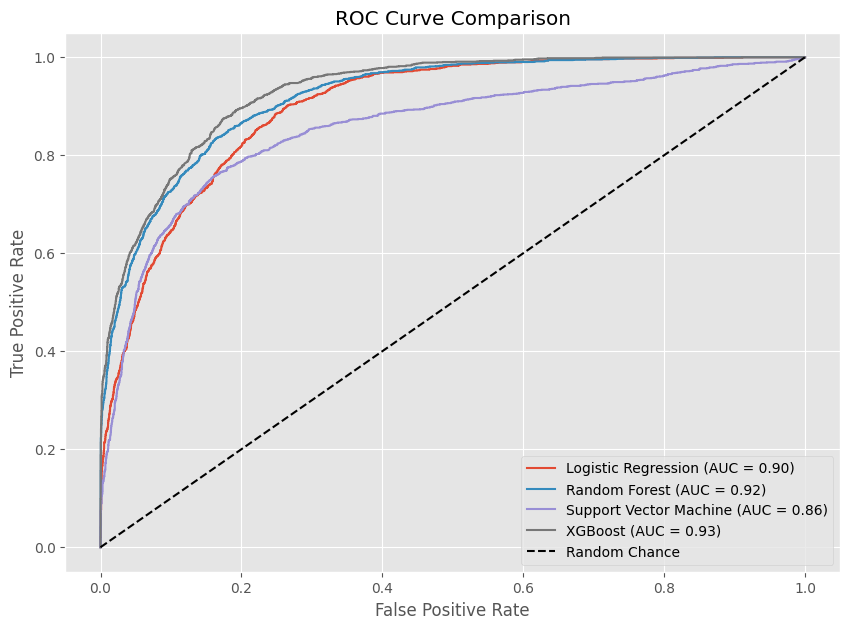

In [104]:
results_models = {'Logistic Regression': results_logreg,
            'Random Forest': results_rf,
            'Support Vector Machine': results_svm,
            'XGBoost': results_xgb}

plot_metrics(results_models)
plot_roc_curves(results_models, X_val, Y_val)

# 8. Conclusion and Prediction Submission

From the AUC metrics for the ROC curves and also the accuracy and f1-weighted scores, we conclude that the XGBoost classifier is the best for this task. So we'll use it to predict the targets for the `X_test` set and them we'll submit the prediction to Kaggle.

In [105]:
# Fit model with best params on whole training set
X_train_full = df_train.drop(['Education Number', 'Native Country', 'Final Weight', 'Relationship', 'Race', 'Target'], axis=1)
Y_train_full = df_train['Target']
best_params = results_xgb['best_params']
xgb_best_model = XGBClassifier(**best_params, eval_metric='logloss', random_state=42)
xgb_best_model.fit(X_train_full, Y_train_full)

# Predict on test set
Y_test_pred = xgb_best_model.predict(X_test)

# Create DataFrame
Y_pred_df = pd.DataFrame({
                            'Id': X_test.index,
                            'income': Y_test_pred})
Y_pred_df.set_index('Id', inplace=True)
Y_pred_df.head()

,income
Id,
0,0
1,1
2,0
3,0
4,1


In [106]:
def translate_Y(y):
    if y == 1:
        return '>50K'
    else:
        return '<=50K'

In [107]:
Y_pred_df['income'] = Y_pred_df['income'].apply(translate_Y)
Y_pred_df.head()

,income
Id,
0,<=50K
1,>50K
2,<=50K
3,<=50K
4,>50K


In [108]:
Y_pred_df.to_csv('data/submission.csv')